<a href="https://www.kaggle.com/code/bbernoturbiz/p8-plantseedlings?scriptVersionId=92731120" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# utility
import os
import pathlib
import datetime as dt
from tqdm import tqdm

# data
import numpy as np
import pandas as pd

# image
import cv2 as cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# ML
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout   #, Rescaling, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
start = dt.datetime.now()

# Paramètres

In [3]:
# Image size for Xception
img_width, img_height = 299, 299   
batch_size = 16

# Path to data
data_dir = "../input/plant-seedlings-classification"

# Réduction eventuelle du dataset à sub_samples images par classe
# 200 pour avoir approximativement la moitié du set, 0 pour tout le set
sub_samples = 0  

# Split train/val
split = 0.2

# Use preprocess ? 
# -- Augmente significativement le score d'accuracy !
detourage = True     
# -- mauvais impact, en plus d'être très long
nl_means = False     

# Random seed
SEED = 427

# Data

## Data path

In [4]:
train_data_dir = data_dir+"/train"
val_data_dir = train_data_dir     #on split train pour validation
test_data_dir = data_dir+"/test"

labels = sorted(os.listdir(train_data_dir))
print(labels)

data_dir

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


'../input/plant-seedlings-classification'

In [5]:
data = []
for category_id, category in enumerate(labels):
    for file in os.listdir(os.path.join(train_data_dir, category)):
        data.append(['{}/{}/{}'.format(train_data_dir, category, file), category_id, category])
data = pd.DataFrame(data, columns=['filepath', 'category_id', 'category'])
display(data.head(2))
print(data.shape)

,filepath,category_id,category
0,../input/plant-seedlings-classification/train/...,0,Black-grass
1,../input/plant-seedlings-classification/train/...,0,Black-grass


(4750, 3)


array([[<AxesSubplot:title={'center':'category_id'}>]], dtype=object)

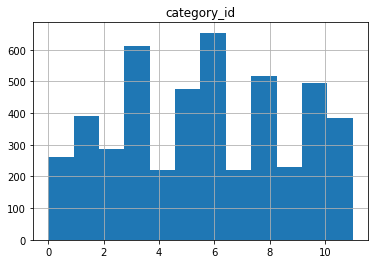

In [6]:
data.hist(column='category_id', bins=12)

In [7]:
test = []
for file in sorted(os.listdir(test_data_dir)):
    test.append(['{}/{}'.format(test_data_dir, file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
display(test.head(2))
print(test.shape)

,filepath,file
0,../input/plant-seedlings-classification/test/0...,0021e90e4.png
1,../input/plant-seedlings-classification/test/0...,003d61042.png


(794, 2)


## Sub sample

In [8]:
## Sub-sample pour tests plus rapide et eviter dépassement mémoire
if sub_samples > 0:
    data = pd.concat([data[data['category'] == c][:sub_samples] for c in labels])
    data = data.sample(frac=1)
    data.index = np.arange(len(data))
    display(data.head(2))
    print(data.shape)

## Split train/val

In [9]:
stratified_split = True ##because inbalanced data
if stratified_split:
    df_train_x, df_val_x, train_y, val_y = train_test_split(data['filepath'], data['category_id'], test_size=split, random_state=SEED, stratify=data['category_id'])
    print(df_train_x.shape, df_val_x.shape, train_y.shape, val_y.shape)
else:
    np.random.seed(seed=SEED)
    rnd = np.random.random(len(data))
    train_idx = rnd > split
    valid_idx = rnd <= split
    train_y = data.loc[train_idx, 'category_id'].values
    val_y = data.loc[valid_idx, 'category_id'].values
    # df_... contiennent les filenames
    df_train_x = data.loc[train_idx, 'filepath'].values
    df_val_x = data.loc[valid_idx, 'filepath'].values

print("{} images for train".format(len(df_train_x)))
print("{} images for validation".format(len(df_val_x)))

(3800,) (950,) (3800,) (950,)
3800 images for train
950 images for validation


# Preprocess spécifique: par la couleur, vu que l'herbe est verte !

On converti l'image en HSV (Hue-Saturation-Value) afin de pouvoir créer un masque des zones "vertes", qui est ensuite appliqué à l'image pour la détourer

   ![HSV](https://www.mathworks.com/help/images/hsvcone.gif)


In [10]:
def create_mask_for_plant(image):
    sensitivity=35    # Note: testé, c'est la meilleure valeur 
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [11]:
def preprocessing_cnn(img, mask_grass=False, nl_means=False):
    if mask_grass:
        img_segmented = segment_plant(img)
        img = sharpen_image(img_segmented)
    if nl_means:
        # Apply non-local means filter on test img
        img = cv2.fastNlMeansDenoisingColored(
            src=img.astype(np.uint8),
            dst=None,
            h=10,
            hColor=10,
            templateWindowSize=7,
            searchWindowSize=21)
    return img

def show_image_preprocc(image):
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    image_nlmeans = preprocessing_cnn(image_sharpen, nl_means=True)
    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    axs[0].imshow(image)
    axs[1].imshow(image_mask)
    axs[2].imshow(image_segmented)
    axs[3].imshow(image_sharpen)
    axs[4].imshow(image_nlmeans)

## Apercu des filtres
    1ère image: original
    2ème image: masque, basé sur le filtre HSV pour selectionner le vert
    3ème image: image originale avec application du masque
    4ème image: application d'un filtre Gaussien sur la 3eme image    
                --> on utilise celle-ci
    5ème image: application d'un Non-local Means filter surr la 4eme image
                --> il prends pas mal de temps et baisse le score final, donc nous ne l'utiliserons pas

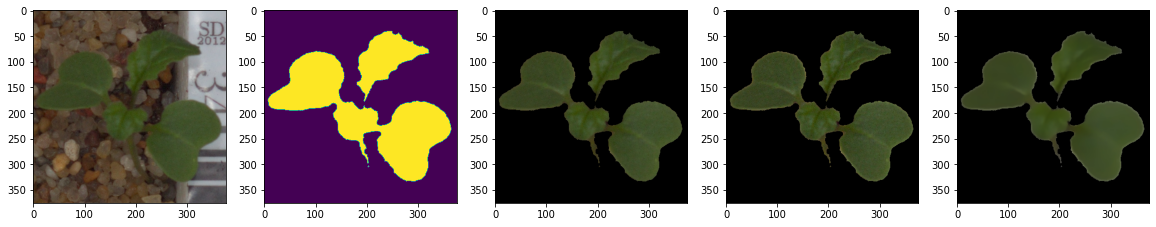

In [12]:
# Test image to see the changes, from a train sample
class_indix = 1   # 0-11
img_indix = 1    # < num images dans cette classe !
#image_filename = sorted(os.listdir(os.path.join(train_data_dir, labels[class_indix])))[img_indix]
#image_path = os.path.join(train_data_dir, labels[class_indix],image_filename)

list_files_cat = data['filepath'][data['category_id']==class_indix].reset_index(drop=True)
image_path = list_files_cat[img_indix]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image_preprocc(image)

# Load images, preprocess

Read image with OpenCV, convert to RGB (OpenCV use BGR), resize, custom preprocess, Xception preprocess

In [13]:
train_x = np.zeros((len(df_train_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_train_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    train_x[i] = x
print('Train Images shape: {} size: {:,}'.format(train_x.shape, train_x.size))

3800it [01:15, 50.65it/s]

Train Images shape: (3800, 299, 299, 3) size: 1,019,171,400


In [14]:
val_x = np.zeros((len(df_val_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_val_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    val_x[i] = x
print('Validation Images shape: {} size: {:,}'.format(val_x.shape, val_x.size))

950it [00:19, 49.15it/s]

Validation Images shape: (950, 299, 299, 3) size: 254,792,850


## Random images from training set

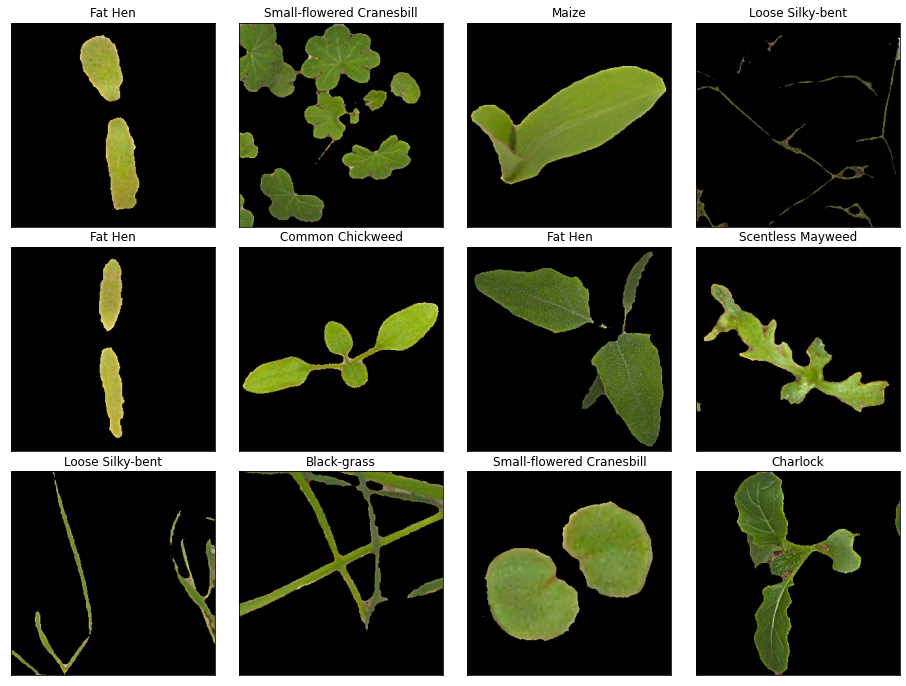

In [15]:
y_true_s = [labels[y] for y in train_y]

sample_idxs = np.arange(len(train_x))
np.random.shuffle(sample_idxs)
picks = sample_idxs[:12]

fig = plt.figure(1, figsize=(16,12))
for i, r in enumerate(picks):
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(tf.keras.utils.array_to_img(train_x[r]))
    plt.title('{}'.format(y_true_s[r]))
    plt.xticks([]) , plt.yticks([])
    
plt.show()


# Transfert Learning from Xception - Feature Extraction

In [16]:
# Import Xception trained model
transfer_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', input_shape=(img_height, img_width, 3))
#transfer_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
### !!! Inception a une sortie de shape (n, 8, 8, ###), au lieu du classique (n, ###), du coup y'a que Fully-connected qui gere ca (ou Flatten?)
INPUTOK = True


# Extract Features from dataset 
train_x_bf = transfer_model.predict(train_x, batch_size=batch_size, verbose=1)
val_x_bf = transfer_model.predict(val_x, batch_size=batch_size, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(val_x_bf.shape, val_x_bf.size))

2022-04-11 15:15:02.586676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:15:02.662861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:15:02.663666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:15:02.665125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


2022-04-11 15:15:06.642999: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4076685600 exceeds 10% of free system memory.
2022-04-11 15:15:11.061478: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4076685600 exceeds 10% of free system memory.
2022-04-11 15:15:13.983975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-11 15:15:15.330712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


238/238 [==============================] - 23s 68ms/step


2022-04-11 15:15:36.640943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1019171400 exceeds 10% of free system memory.
2022-04-11 15:15:37.833520: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1019171400 exceeds 10% of free system memory.


60/60 [==============================] - 4s 70ms/step
Xception train bottleneck features shape: (3800, 2048) size: 7,782,400
Xception valid bottleneck features shape: (950, 2048) size: 1,945,600


## Plot function

In [17]:
def plot_acc_loss(history, metrics = None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # au cas ou le callback EarlyStopping arrete avant fin des epochs, on prend la taille réelle
    epochs_range = range(len(loss))

    num_subplot = 2
    if metrics is not None:
        num_subplot += len(metrics)

    plt.figure(figsize=(8+2*num_subplot, 8))
    plt.subplot(1, num_subplot, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:    #sometimes errors prevent validation, we still want training
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, num_subplot, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    if metrics is not None:
        for i, met in enumerate(metrics):
            m = history.history[met]
            val_m = history.history['val_'+met]
            plt.subplot(1, num_subplot, 3+i)
            plt.plot(epochs_range, m, label='Training '+met)
            if val_m is not None:
                plt.plot(epochs_range, val_m, label='Validation '+met)
            plt.legend()
            plt.title('Training and Validation '+met)
        
    plt.show()

# Classifiers

We test 3 models: RandomForestClassifier, LogisticRegression, and a NeuralNetwork (Multi-Layer Perceptron)

In [18]:
classifier = {}

def train_predict_score(model, train_x, train_y, val_x, val_y):
    t0 = dt.datetime.now()
    model.fit(train_x, train_y)
    val_preds = model.predict(val_x)
    val_probs = model.predict_proba(val_x)
    score = accuracy_score(val_y, val_preds)
    t = dt.datetime.now()-t0
    print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
    return val_preds, val_probs, score, t

## RandomForestClassifier

In [19]:
if INPUTOK:
    rfc = RandomForestClassifier()
    val_pred, val_prob, score, t = train_predict_score(rfc, train_x_bf, train_y, val_x_bf, val_y)
    print('Validation Xception+RandomForestClassifier Accuracy {}'.format(score))

    classifier['rfc'] = (rfc, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 10 sec
Validation Xception+RandomForestClassifier Accuracy 0.8568421052631578


## LogisticRegression

In [20]:
if INPUTOK:
    logreg = LogisticRegression(multi_class='multinomial', solver='sag', random_state=SEED, max_iter=200)
    val_pred, val_prob, score, t = train_predict_score(logreg, train_x_bf, train_y, val_x_bf, val_y)
    print('Validation Accuracy [Xception+LogisticRegression]: {}'.format(score))

    classifier['logreg'] = (logreg, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 69 sec
Validation Accuracy [Xception+LogisticRegression]: 0.9084210526315789


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Fully-Connected

Epoch 1/30
3800/3800 [==============================] - 14s 3ms/step - loss: 1.5379 - accuracy: 0.5563 - val_loss: 0.8738 - val_accuracy: 0.7411
Epoch 2/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.7939 - accuracy: 0.7532 - val_loss: 0.5720 - val_accuracy: 0.8305
Epoch 3/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.5690 - accuracy: 0.8292 - val_loss: 0.4580 - val_accuracy: 0.8579
Epoch 4/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.4632 - accuracy: 0.8539 - val_loss: 0.3928 - val_accuracy: 0.8768
Epoch 5/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.3926 - accuracy: 0.8734 - val_loss: 0.3561 - val_accuracy: 0.8789
Epoch 6/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.3345 - accuracy: 0.8929 - val_loss: 0.3458 - val_accuracy: 0.8768
Epoch 7/30
3800/3800 [==============================] - 12s 3ms/step - loss: 0.3078 - accuracy: 0.8955 - val_loss: 0.3171 - val_ac

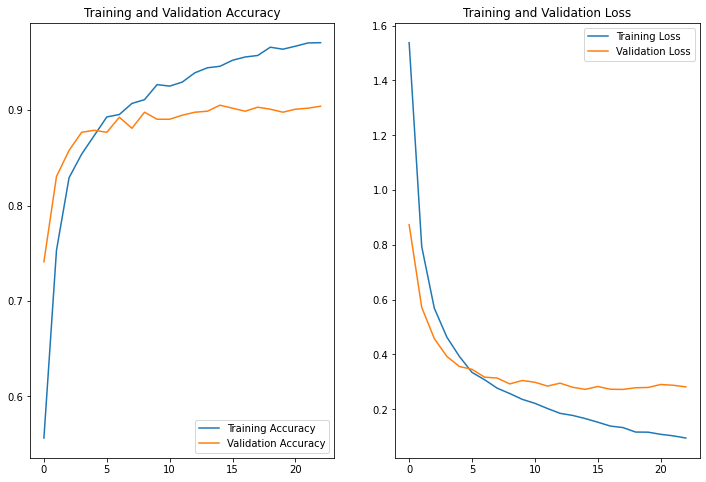

Validation Xception+Fully-connected Accuracy 0.9042105263157895


In [21]:
if True:
    fully_connected = Sequential([
        Flatten(),
        Dense(100, activation='relu'),
        tf.keras.layers.BatchNormalization(trainable=False, axis=1),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(len(labels), activation='softmax')
    ])
    # Compiler le modèle
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00004, beta_1=0.9, beta_2=0.999)
    fully_connected.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    t0 = dt.datetime.now()
    history = fully_connected.fit(
        x = train_x_bf,
        y = train_y,
        steps_per_epoch= train_x.shape[0],
        epochs=30,
        validation_data=(val_x_bf, val_y),
        validation_steps=val_x_bf.shape[0],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )

    fc_valid_preds_res = fully_connected.predict(val_x_bf)
    fc_valid_preds = np.argmax(fc_valid_preds_res, axis=1)
    fc_valid_probs = np.max(fc_valid_preds_res, axis=1)
    fc_score = accuracy_score(val_y, fc_valid_preds)
    t = dt.datetime.now()-t0
    print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
    plot_acc_loss(history)
    print('Validation Xception+Fully-connected Accuracy {}'.format(fc_score))

    classifier['fc'] = (fully_connected, fc_valid_preds, fc_valid_probs, fc_score, t)

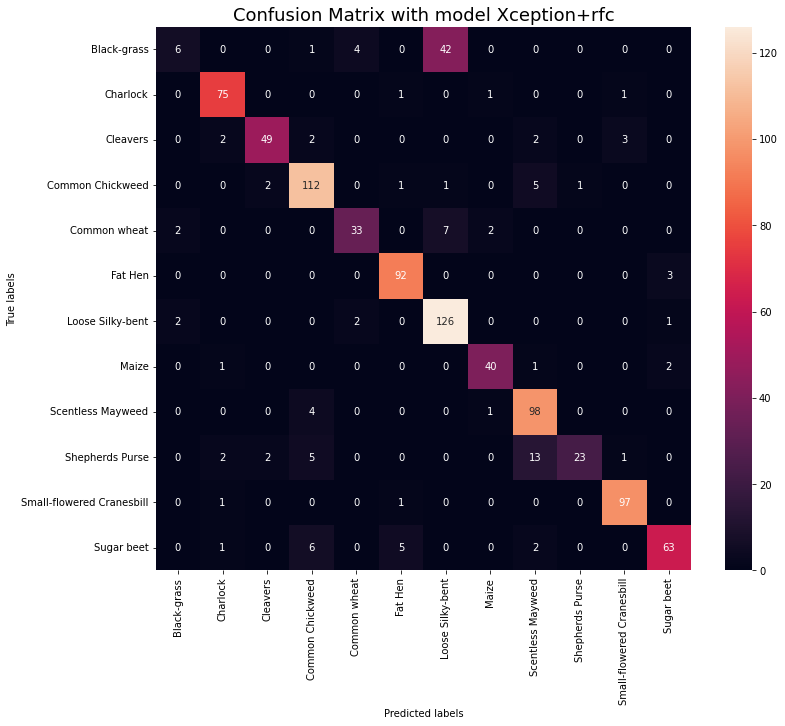

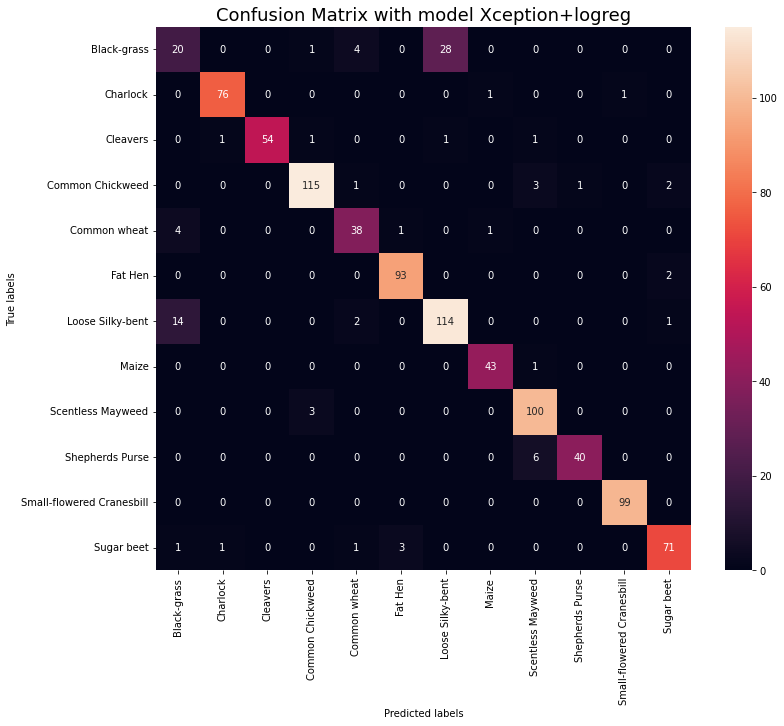

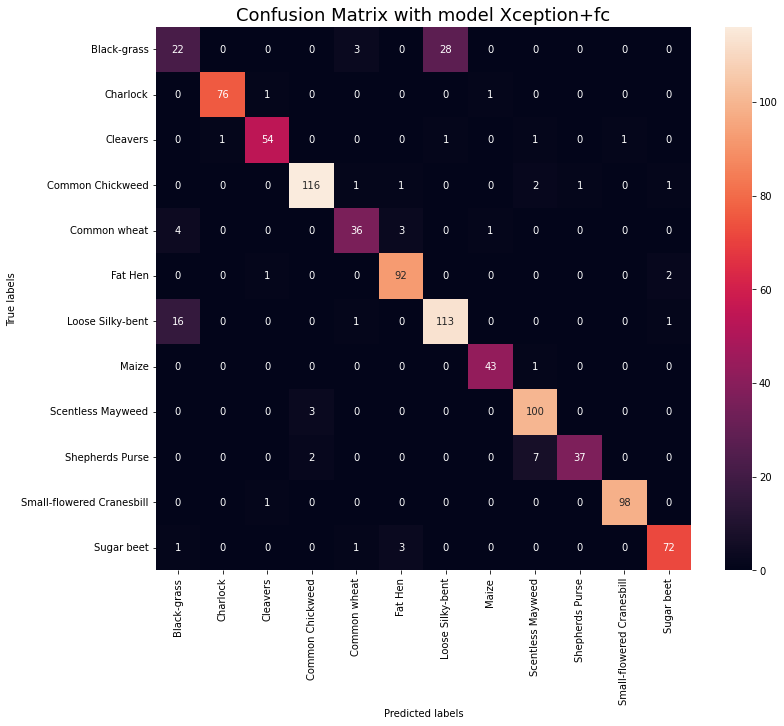

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for key in classifier:
    # Use predictions
    y_pred = classifier[key][1]

    # Confusion Matrix
    cf_matrix = confusion_matrix(val_y, y_pred, labels=range(len(labels)))

    fig = plt.figure(figsize=(12,10))
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.xaxis.set_ticklabels(labels, rotation='vertical')
    ax.yaxis.set_ticklabels(labels, rotation='horizontal')
    plt.title("Confusion Matrix with model Xception+"+key, fontsize=18)
    plt.show()

In [23]:
best_score = 0.0
best_classifier_key = ''
print("classifier \t score \t\t time")
for key in classifier:
    score = classifier[key][3]
    print("{}\t{}\t{}".format(key, score, classifier[key][4]))
    if score > best_score:
        best_score = score
        best_classifier_key = key        
print("\nBest classifier: {}  - score: {}".format(best_classifier_key, best_score))

classifier 	 score 		 time
rfc	0.8568421052631578	0:00:10.077493
logreg	0.9084210526315789	0:01:09.109417
fc	0.9042105263157895	0:05:22.895527

Best classifier: logreg  - score: 0.9084210526315789


# Random Validation Samples predictions

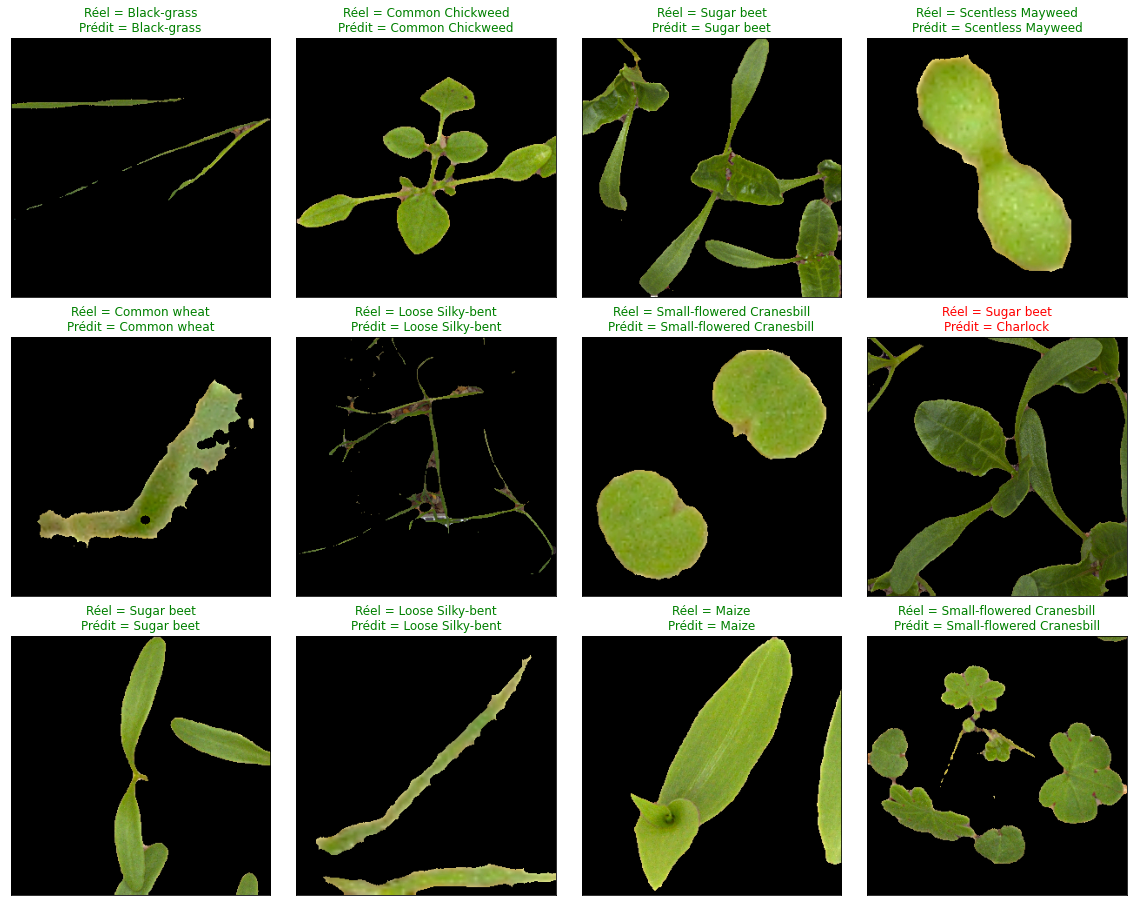

In [24]:
# Exemples au hasard dans set validation, avec dernier modele de la confusion matrix

# Inverse transform of encoding
y_true_s = [labels[x] for x in val_y]
y_pred_s = [labels[x] for x in classifier[best_classifier_key][1]]

fig = plt.figure(1, figsize=(20,16))
test_idxs = np.arange(len(val_x))
np.random.shuffle(test_idxs)
picks = test_idxs[:12]
for i, r in enumerate(picks):
    batch_r = r // batch_size
    idx_r = r % batch_size
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(tf.keras.utils.array_to_img(val_x[r]))
    plt.title('Réel = {}\nPrédit = {}'.format(y_true_s[r], y_pred_s[r]), color= 'green' if y_true_s[r] == y_pred_s[r] else 'red')
    plt.xticks([]) , plt.yticks([])
    
plt.show()

## Predict an image class with models

prediction(rfc): Small-flowered Cranesbill  (85.0)
prediction(logreg): Small-flowered Cranesbill  (99.97422099113464)
prediction(fc): Small-flowered Cranesbill  (99.99774694442749)


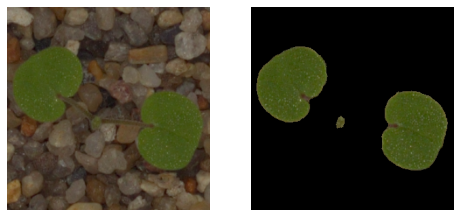

In [25]:
# example of using a pre-trained model as a classifier
#from keras.preprocessing.image import load_img

image_path = os.path.join(data_dir,'test/0021e90e4.png')
#image_path = os.path.join(data_dir,'train/Small-flowered Cranesbill/003402ea0.png')
#image = load_img(image_path, target_size=(img_height, img_width))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (img_width, img_height))

# show image
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image)
plt.axis("off")

if detourage or nl_means:
    image = preprocessing_cnn(image, mask_grass=detourage, nl_means=nl_means)
    plt.subplot(122)
    plt.imshow(image)
    plt.axis("off")

img_array = tf.keras.utils.img_to_array(image)
img_array = preprocess_input(tf.expand_dims(img_array, 0))
img_bf = transfer_model.predict(img_array)

for key in classifier:
    prediction = classifier[key][0].predict(img_bf)
    if key == 'fc':
        prediction_fc = np.argmax(prediction, axis=1)
        prediction_proba_fc = np.max(prediction, axis=1)
        print("prediction({}): {}  ({})".format(key, labels[prediction_fc[0]], 100*prediction_proba_fc[0]))
    else:
        prediction_proba = classifier[key][0].predict_proba(img_bf)
        print("prediction({}): {}  ({})".format(key, labels[prediction[0]], 100*np.max(prediction_proba[0])))


# Submission

In [26]:
test_x = np.zeros((len(test), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(test['filepath'])):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    test_x[i] = x
print('Test Images shape: {} size: {:,}'.format(test_x.shape, test_x.size))

794it [00:12, 62.63it/s]

Test Images shape: (794, 299, 299, 3) size: 212,953,182


In [27]:
test_x_bf = transfer_model.predict(test_x, batch_size=batch_size, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = classifier[best_classifier_key][0].predict(test_x_bf)

2022-04-11 15:23:29.016732: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851812728 exceeds 10% of free system memory.


50/50 [==============================] - 4s 72ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [28]:
# with fully-connected model, need to get best prediction from probas
if best_classifier_key == 'fc':
    test_preds = np.argmax(test_preds, axis=1)

In [29]:
test['category_id'] = test_preds
test['species'] = [labels[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)

In [30]:
print("Total Notebook time: {} sec".format((dt.datetime.now()-start).seconds))

Total Notebook time: 626 sec
